In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import seaborn as sns
from sigvisa import Sigvisa
import numpy as np

import scipy.stats
from sigvisa.database.signal_data import execute_and_return_id
from sigvisa.learn.train_param_common import insert_model
import os

from sigvisa.models.noise.noise_model import NoiseModel
from sigvisa.models.distributions import Gaussian, TruncatedGaussian, InvGamma, MultiGaussian, LogNormal
from sigvisa.utils.fileutils import mkdir_p

In [2]:
from sigvisa.learn.train_noise_priors import train_noise_mean_priors

# Training models for envelope signals

ANMO BHZ
disallowing invgamma model with undefined variance
-inf -2613.71430225 -2674.00684211
best model is tgaussian
params mean [ 0.25814485]
params cov [[ 0.20891768]]
ELK BHZ
params mean [ 0.25233005]
params cov [[ 0.20768031]]
IL31 BHZ
-1026.31213677 -1076.1782302 -1028.49069225
best model is invgamma
params mean [ 0.37011803]
params cov [[ 0.20908353]]
KDAK BHZ
-467.665596517 -452.549928842 -458.275732788
best model is tgaussian
params mean [ 0.36276909]
params cov [[ 0.20753874]]
NEW BHZ
disallowing invgamma model with undefined variance
-inf -666.524307628 -592.266865749
best model is lognormal
params mean [ 0.3715054]
params cov [[ 0.20980063]]
NV01 sz
-1893.72118745 -1916.5096008 -1887.66102549
best model is lognormal
params mean [ 0.40313767]
params cov [[ 0.21308652]]
PD31 bz
-2774.28334988 -2773.12716692 -2768.38539437
best model is lognormal
params mean [ 0.29512148]
params cov [[ 0.21563508]]
PFO BHZ
disallowing invgamma model with undefined variance
-inf -2601.07897113

/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


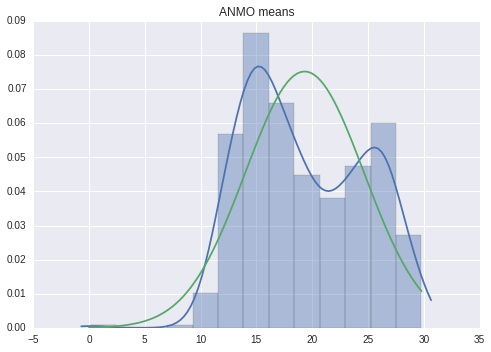

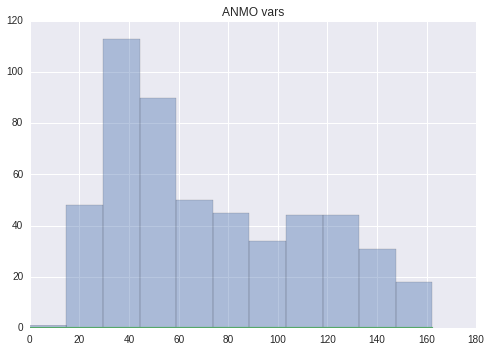

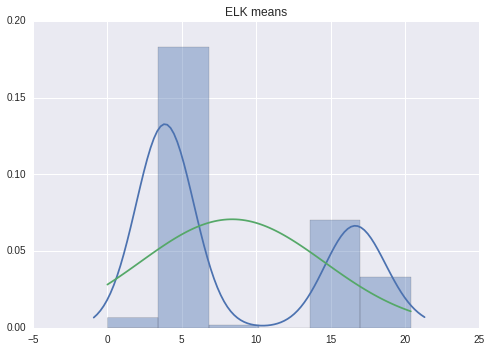

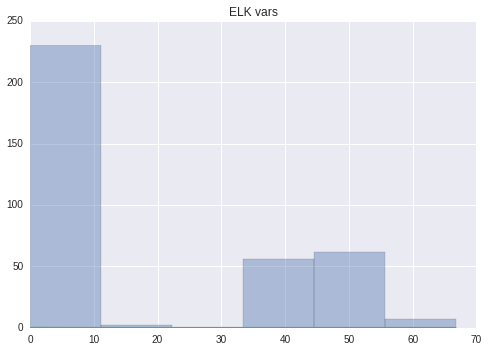

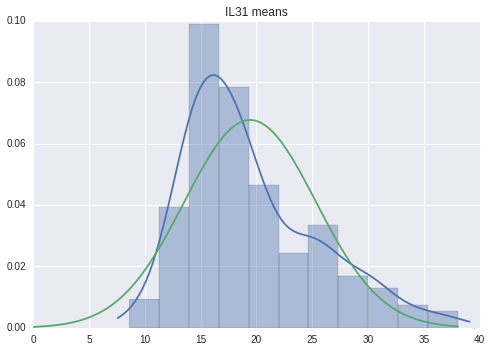

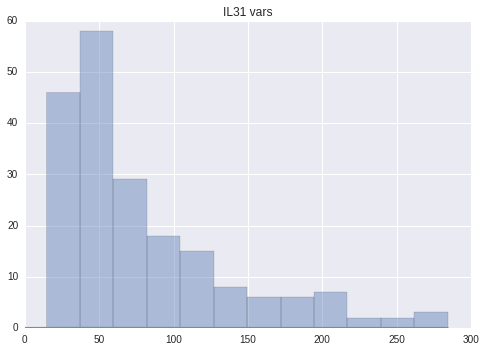

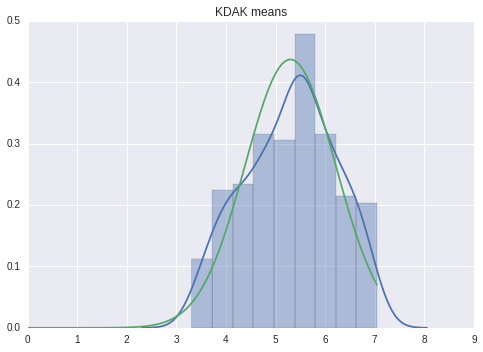

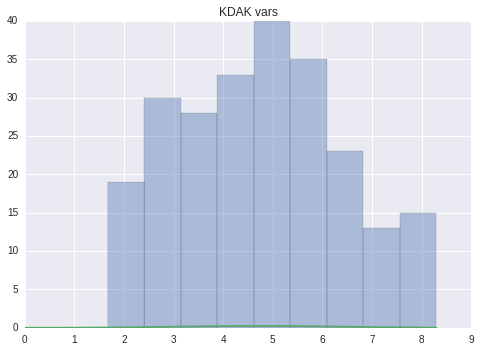

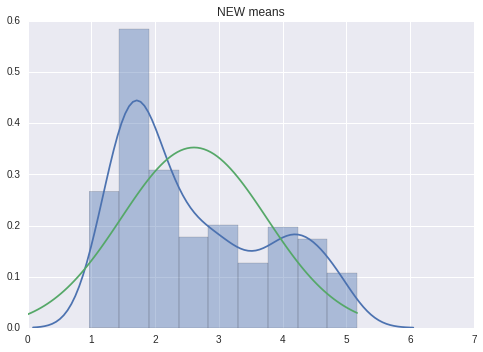

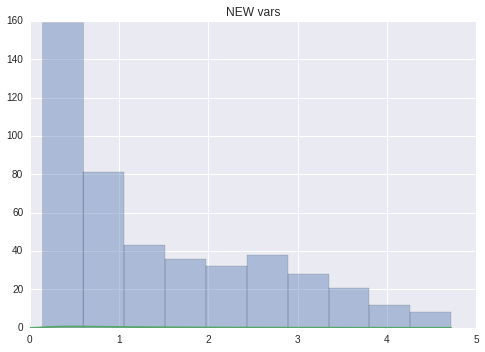

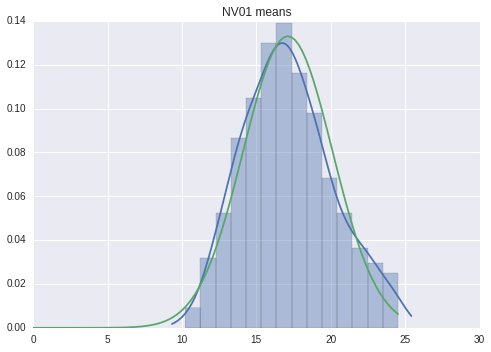

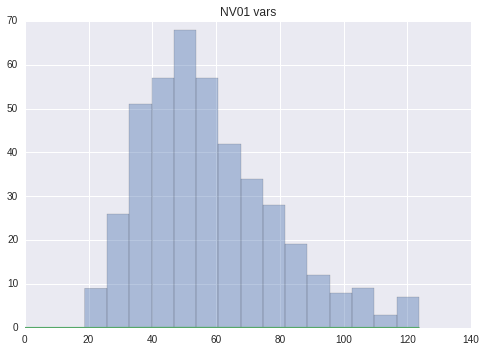

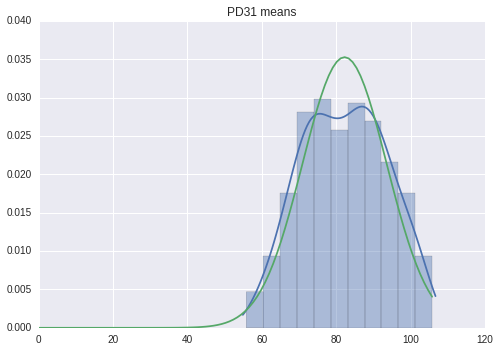

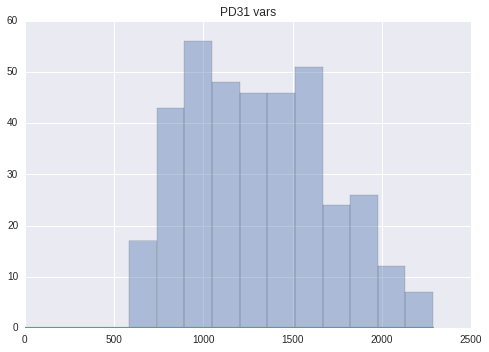

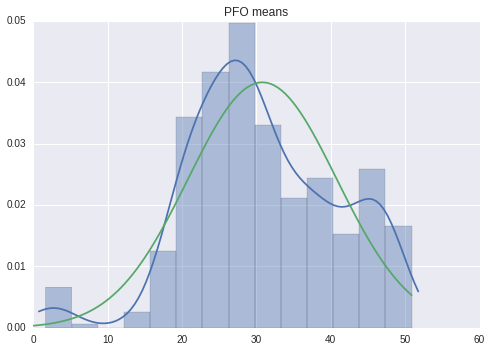

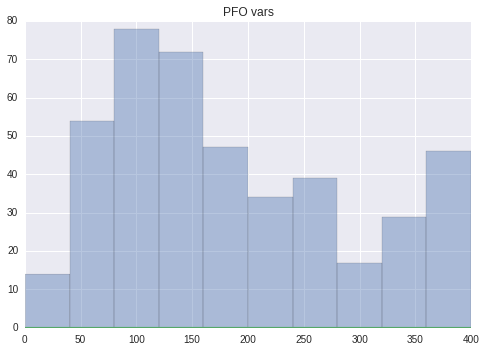

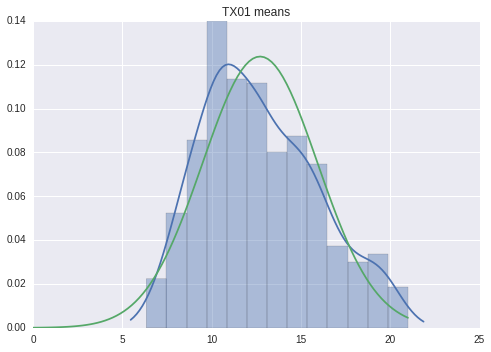

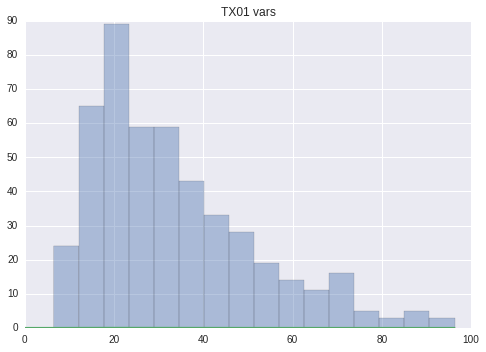

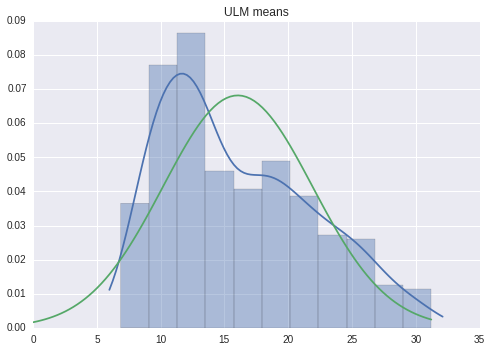

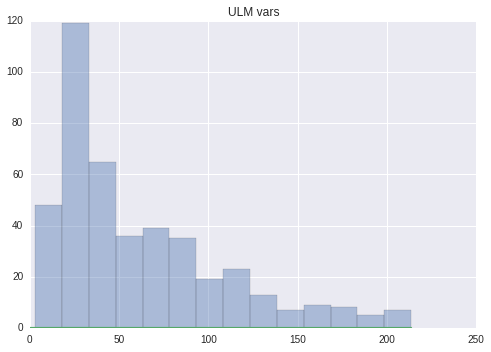

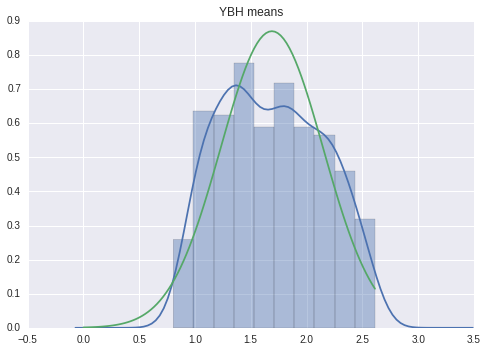

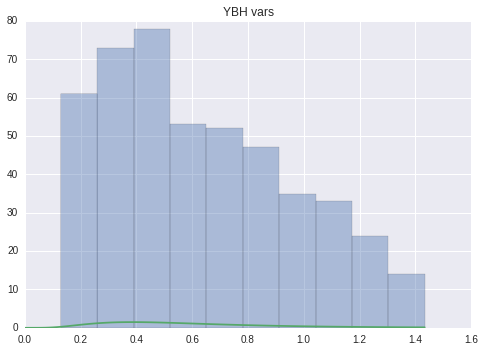

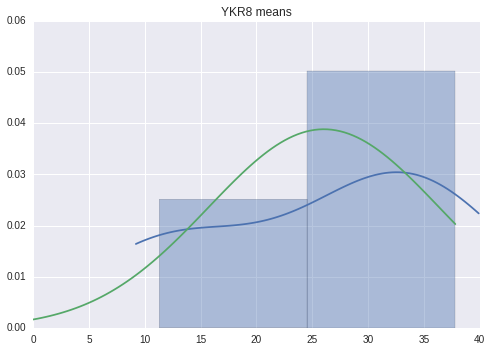

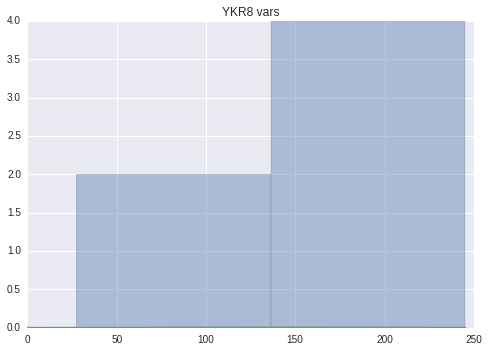

In [3]:


sites="ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
#sites=["NVAR",]
band="freq_2.0_4.5"
hz=2
env=True
llnl=True
for site in sites:
    sta = Sigvisa().get_default_sta(site)
    chan = Sigvisa().default_vertical_channel[sta]
    print sta, chan
    if chan=="sz":
        chan="SHZ"
    if chan=="bz":
        chan="BHZ"
    
    #if sta=="NEW":
    #    cutoff = 50
    #else:
    #    cutoff = None
    
    std_cutoff = None
    #if sta=="NV01":
    #    std_cutoff = 100.0
    if sta=="NV01":
        std_cutoff = 100.0
    elif sta=="PFO":
        std_cutoff=20.0
    elif sta=="YBH":
        std_cutoff=10.0
    elif sta=="TX01":
        std_cutoff=20.0
    elif sta=="PD31":
        std_cutoff=100.0
    elif sta=="IL31":
        std_cutoff=25.0
    elif sta=="ANMO":
        std_cutoff=30.0
    elif sta=="IL31":
        std_cutoff=25.0
    elif sta=="ELK":
        std_cutoff=12.0
    cutoff=None
    low_cutoff=None
        
    train_noise_mean_priors(runid=27, sta=sta, band=band, chan=chan, hz=hz, 
                            env=env, mean_upper_cutoff=cutoff, std_upper_cutoff=std_cutoff,
                            mean_lower_cutoff=low_cutoff, dummy=True, plot=True)

# Training models for raw waveforms

ANMO BHZ
disallowing invgamma model with undefined variance
-inf -3520.20398063 -3763.25127866
best model is tgaussian
params mean [ 0.34199596 -0.58089072  0.19508448 -0.49676274]
params cov [[ 0.2269549  -0.00639714  0.00734923 -0.00046203]
 [-0.00639714  0.21792241 -0.00028412 -0.0030582 ]
 [ 0.00734923 -0.00028412  0.20511348 -0.00122438]
 [-0.00046203 -0.0030582  -0.00122438  0.20248669]]
ELK BHZ
params mean [ 0.27499101 -0.57790688  0.13469505 -0.45916337]
params cov [[  2.48186995e-01  -1.00504306e-02   1.56746721e-02  -3.72891175e-03]
 [ -1.00504306e-02   2.12850127e-01  -5.67195134e-03   1.97031587e-04]
 [  1.56746721e-02  -5.67195134e-03   2.08137547e-01  -1.80441642e-03]
 [ -3.72891175e-03   1.97031587e-04  -1.80441642e-03   2.02061440e-01]]
IL31 BHZ
disallowing invgamma model with undefined variance
-inf -3892.31577447 -3821.62009757
best model is lognormal
params mean [ 0.89618776 -0.80136971  0.43458467 -0.41985561]
params cov [[ 0.24233982 -0.02110718  0.01434473 -0.0011

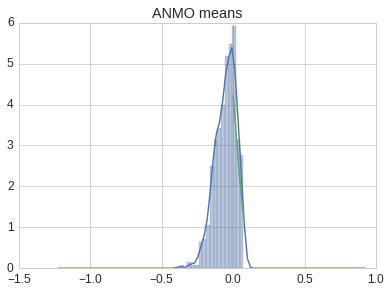

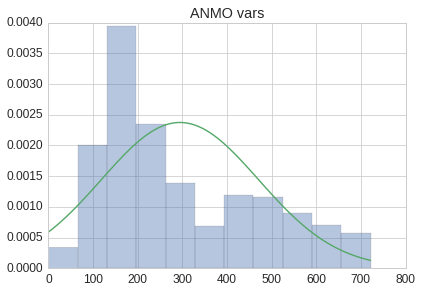

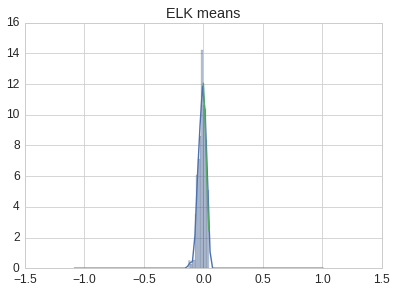

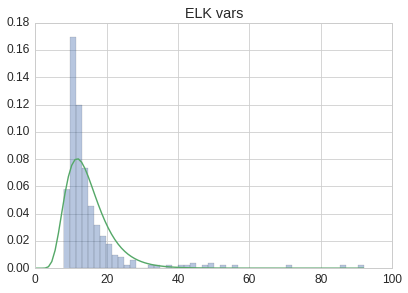

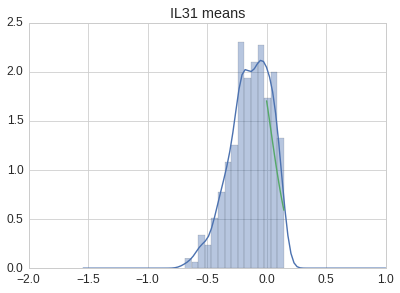

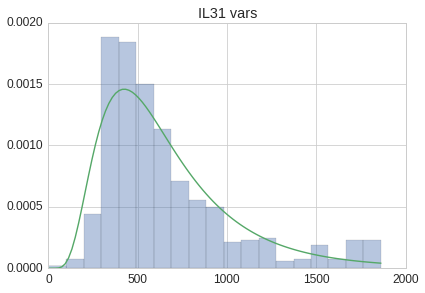

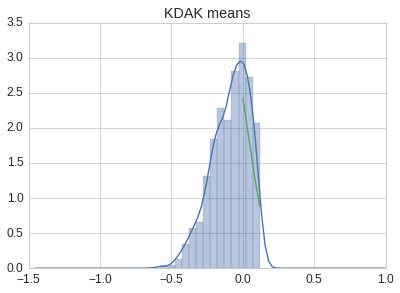

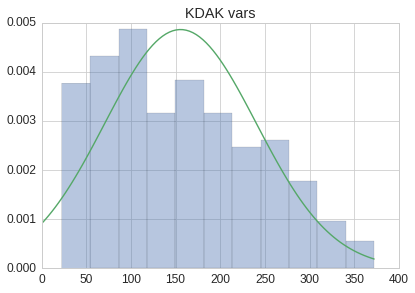

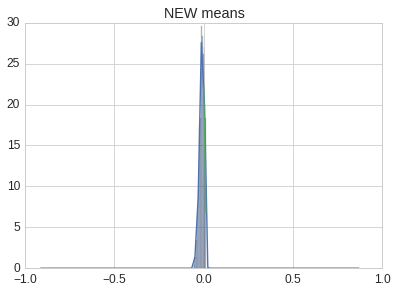

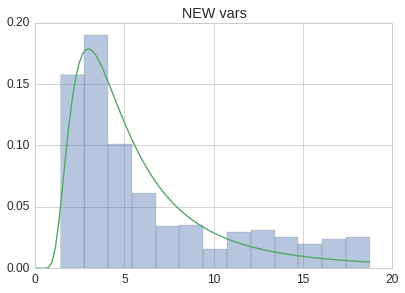

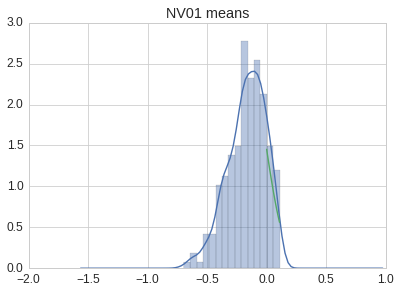

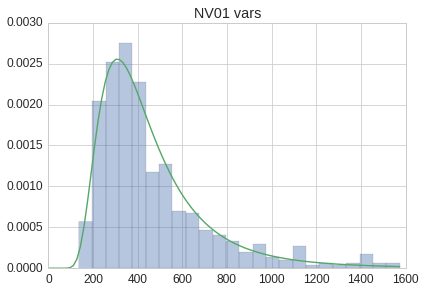

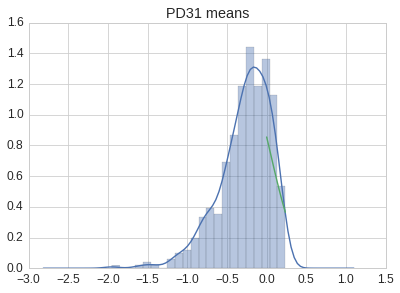

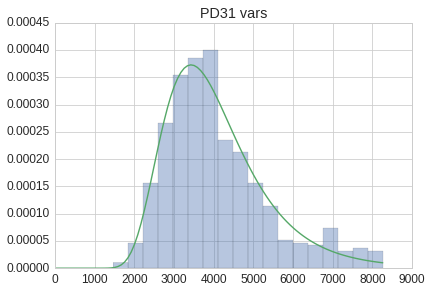

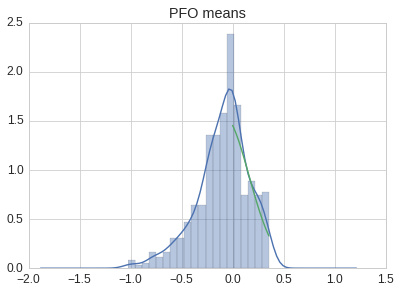

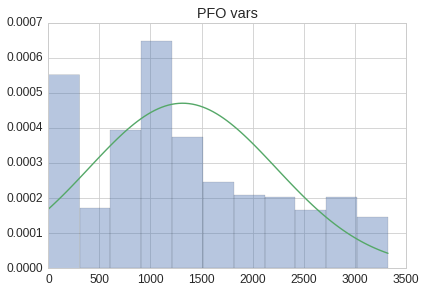

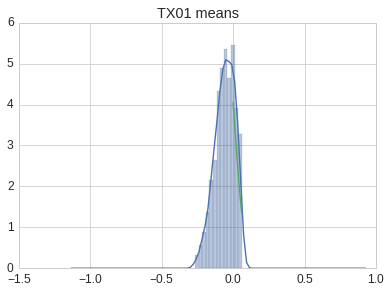

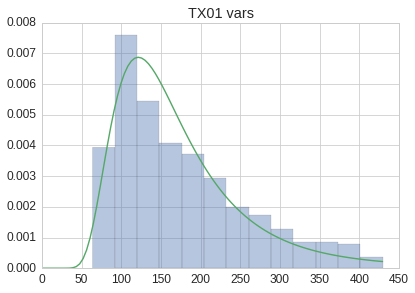

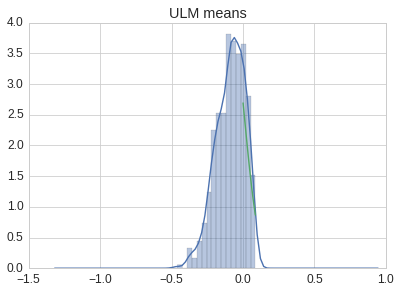

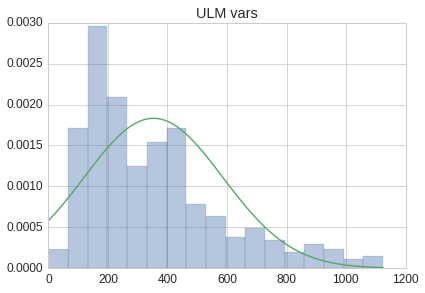

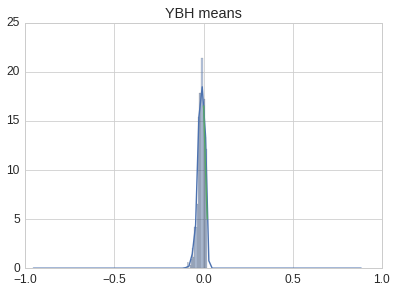

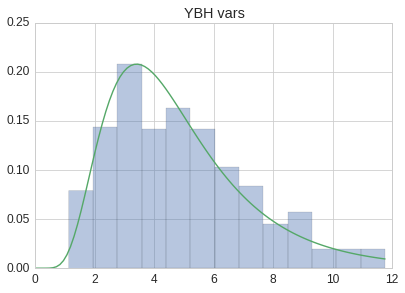

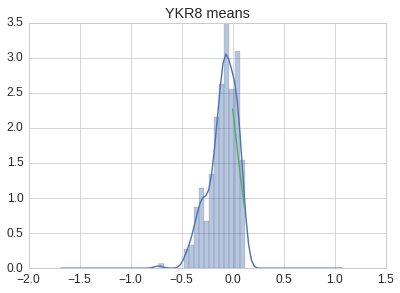

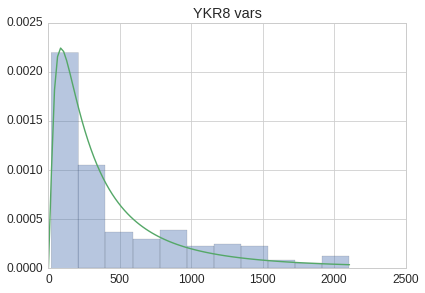

In [5]:


sites="ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
band="freq_0.8_4.5"
hz=10
env=False
llnl=True
#sites=["NV01",]

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

for site in sites:
    sta = Sigvisa().get_default_sta(site)
    chan = Sigvisa().default_vertical_channel[sta]
    print sta, chan
    if chan=="sz":
        chan="SHZ"
    if chan=="bz":
        chan="BHZ"
    
    std_cutoff=None
    std_low = None
    if sta=="PD31":
        std_cutoff = 120
    elif sta=="YRK8":
        std_cutoff = 20
    elif sta=="ELK":
        std_cutoff = 10
        std_low = 2

    
    cutoff=None
    low_cutoff=None
        
    train_noise_mean_priors(runid=25, sta=sta, band="freq_0.8_4.5", chan=chan, hz=hz, 
                            env=env, mean_upper_cutoff=cutoff, std_upper_cutoff=std_cutoff,
                            std_lower_cutoff=std_low,
                            mean_lower_cutoff=low_cutoff, dummy=True, insert_runid=25, plot=True)
    plt.title()

# Investigating scaling differences in LLNL signal data

In [7]:

def plot_levels(sta, runid):
    s = Sigvisa()
    query = "select fp.arrival_time, fp.amp_transfer from sigvisa_coda_fit f, sigvisa_coda_fit_phase fp where f.sta='%s' and f.runid=%d and (fp.phase='P' or fp.phase='Pn') and fp.fitid=f.fitid"% (sta, runid)
    r = s.sql(query)
    r = np.array(r)
    plt.figure()
    plt.scatter(r[:, 0], r[:, 1])
    plt.title("%s amp_transfer" % sta)


    stime = np.min(r[:, 0])
    etime = np.max(r[:, 0])
    query = "select window_stime, mean from sigvisa_noise_model where window_stime between %f and %f and band='freq_0.8_4.5' and sta='%s' and hz=2.0 and env='t' and nmid>300000" % (stime, etime, sta)
    r2 = np.array(s.sql(query))
    plt.figure()
    plt.scatter(r2[:, 0], r2[:, 1])
    plt.ylim([0, np.percentile(r2[:, 1], 99)])
    plt.title("%s noise means (env)" % sta)
    
    
    stime = np.min(r[:, 0])
    etime = np.max(r[:, 0])
    query = "select window_stime, std from sigvisa_noise_model where window_stime between %f and %f and band='freq_0.8_4.5' and sta='%s' and hz=10.0 and env='f' and nmid>300000" % (stime, etime, sta)
    r3 = np.array(s.sql(query))
    plt.figure()
    plt.scatter(r3[:, 0], r3[:, 1])
    plt.ylim([0, np.percentile(r3[:, 1], 99)])
    plt.title("%s noise stds (raw)" % sta)
    
    return r, r2

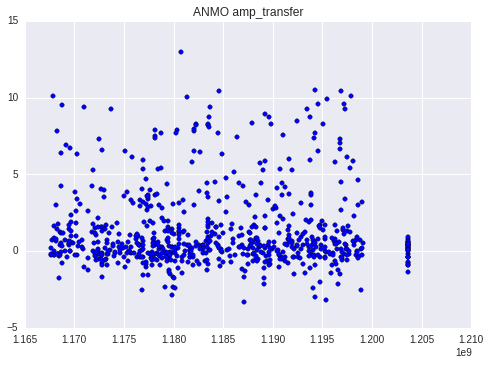

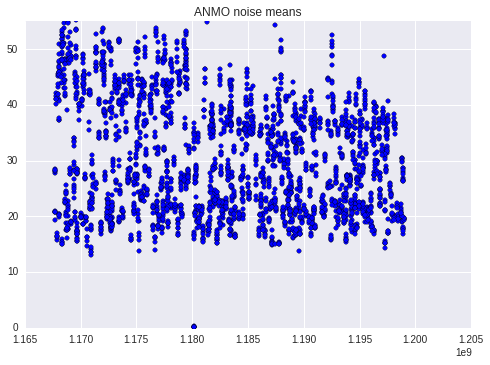

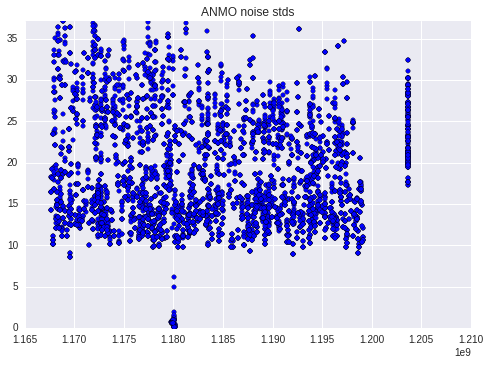

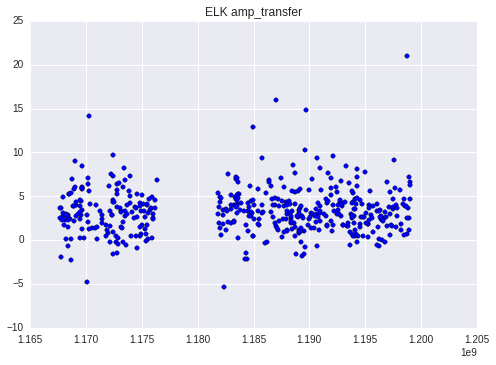

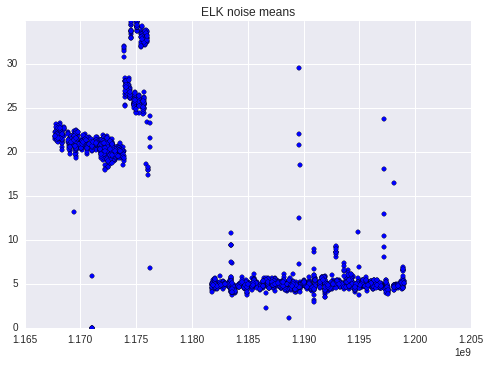

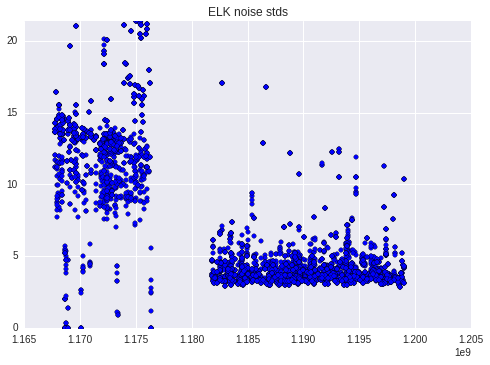

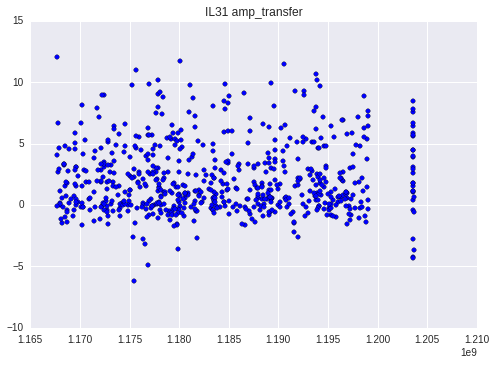

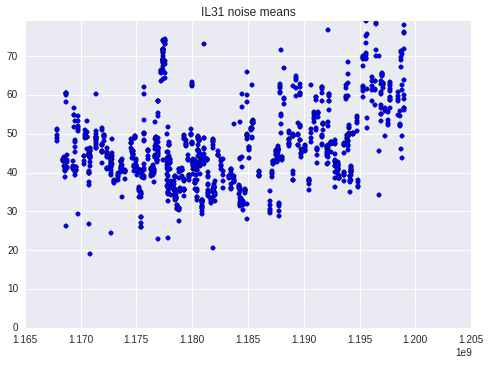

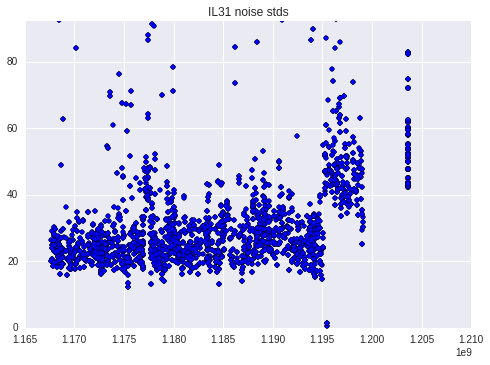

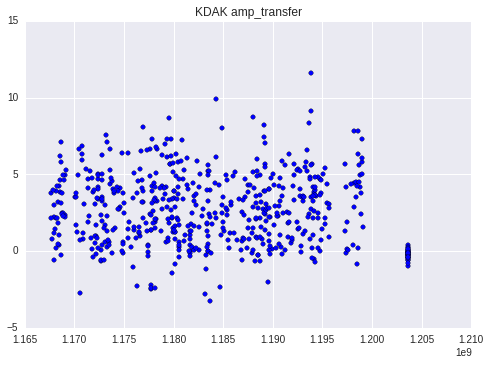

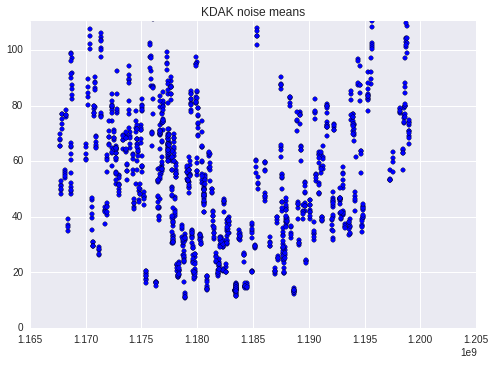

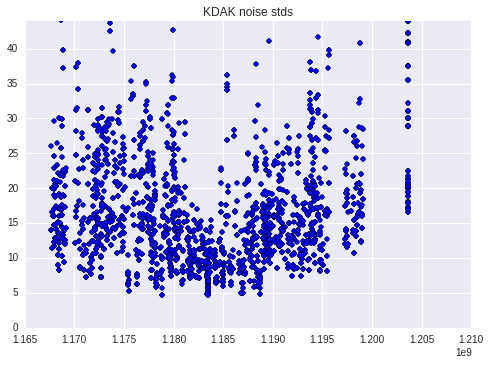

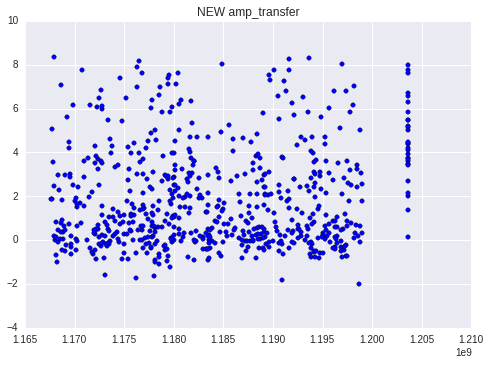

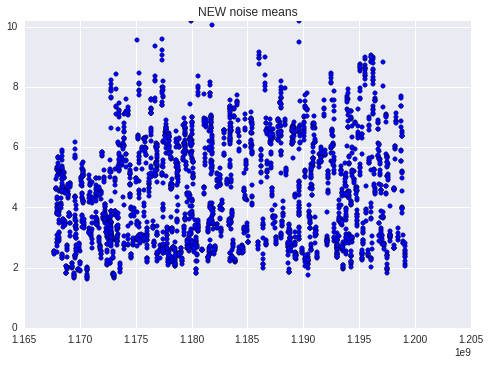

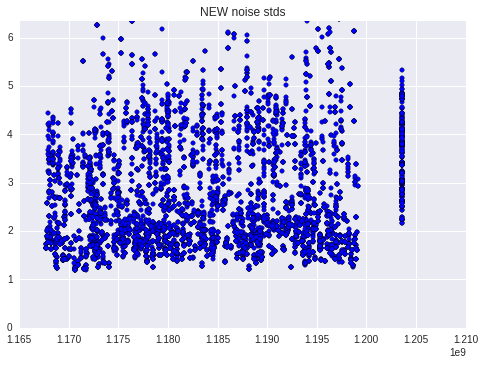

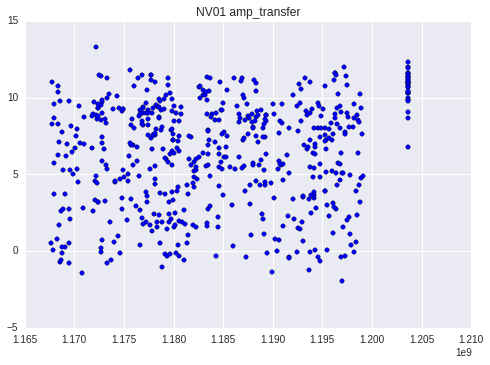

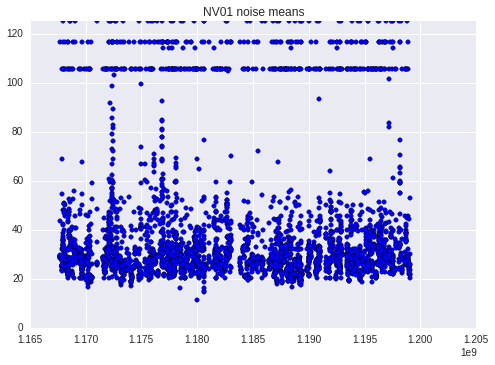

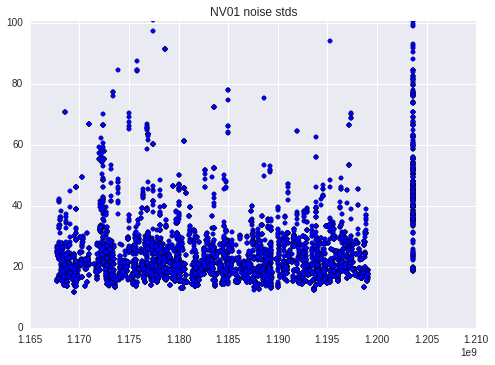

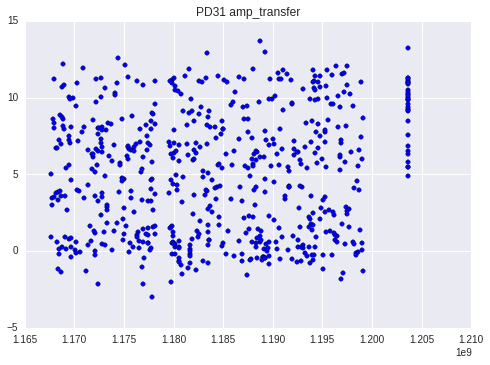

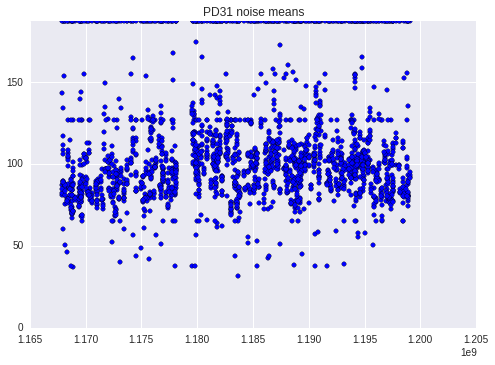

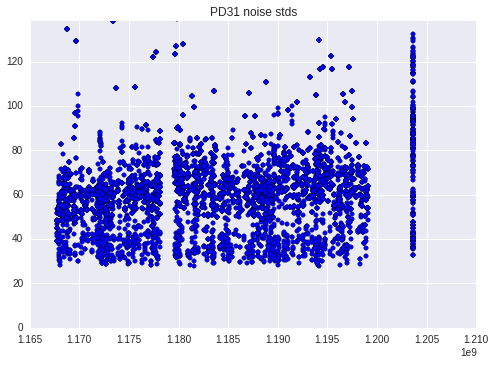

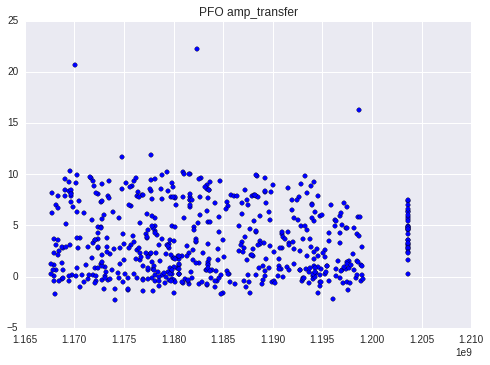

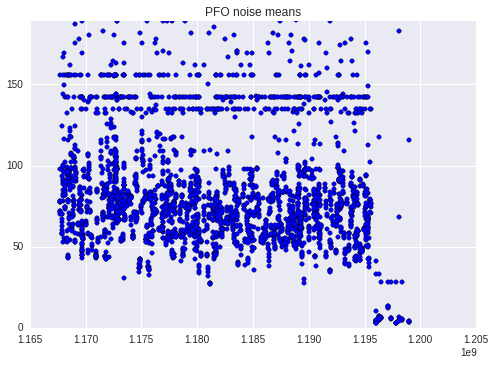

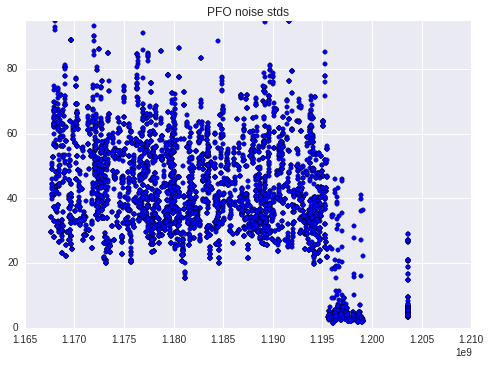

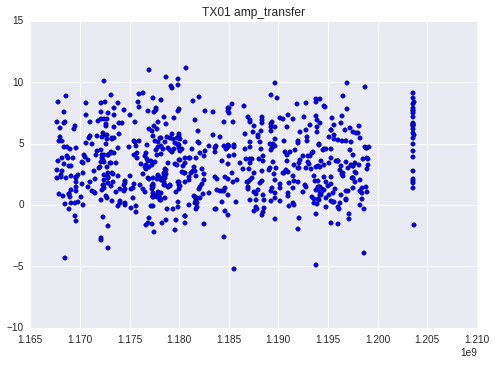

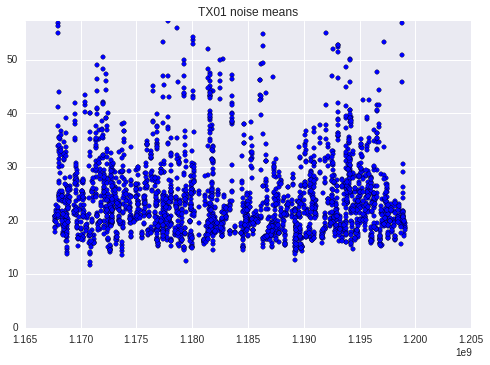

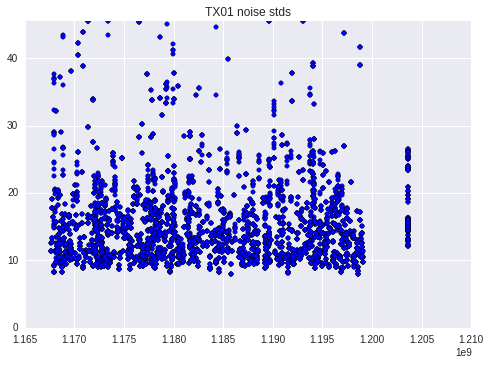

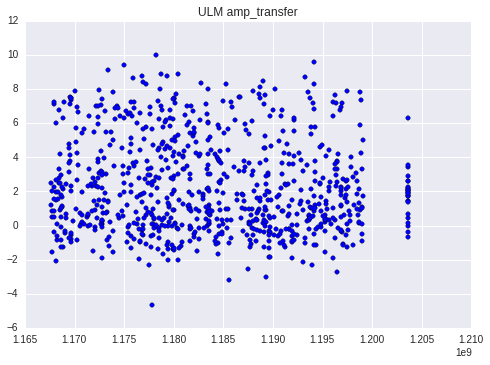

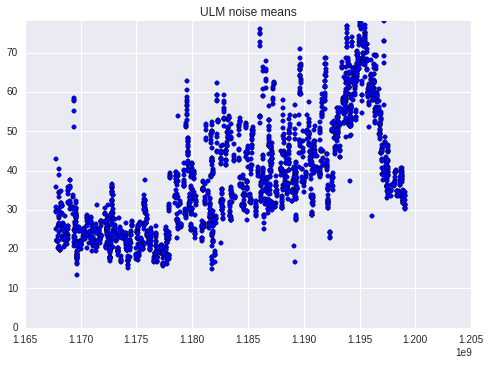

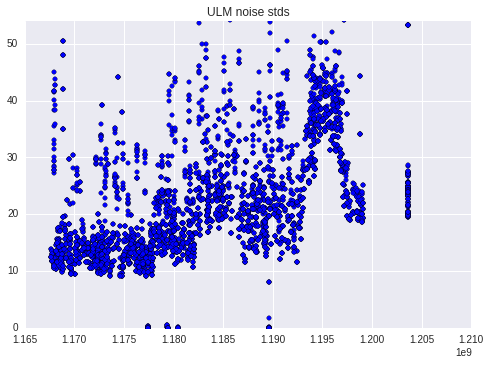

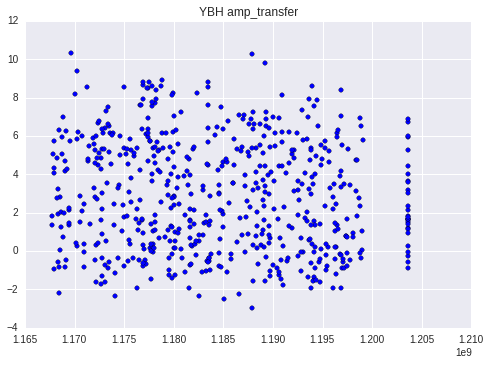

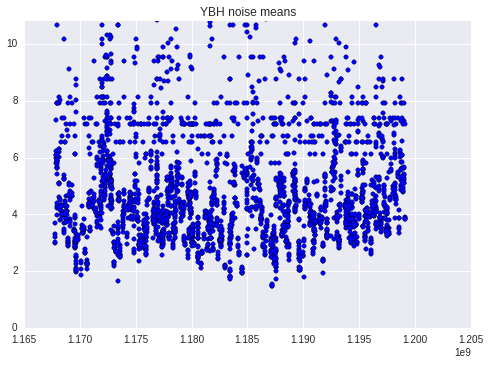

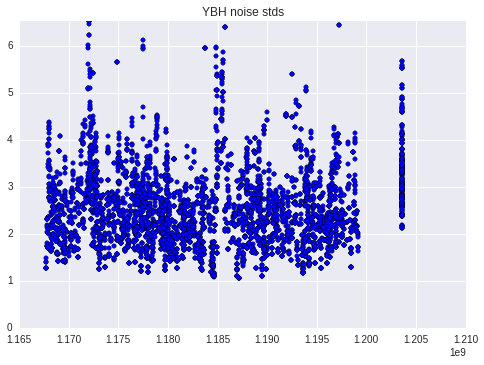

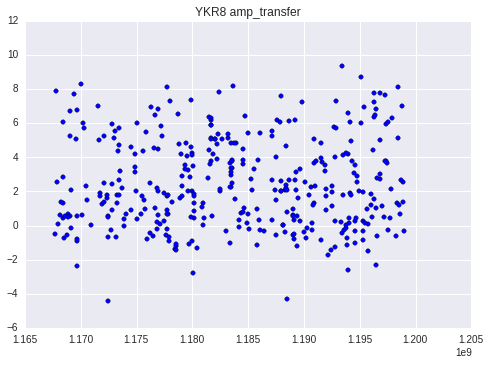

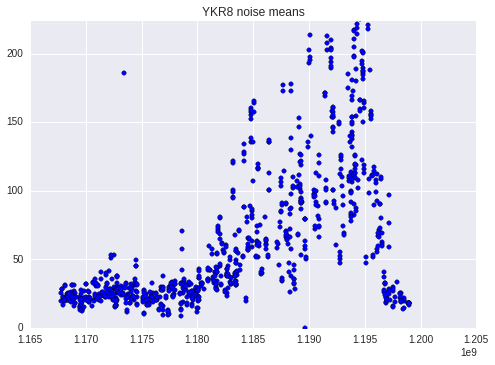

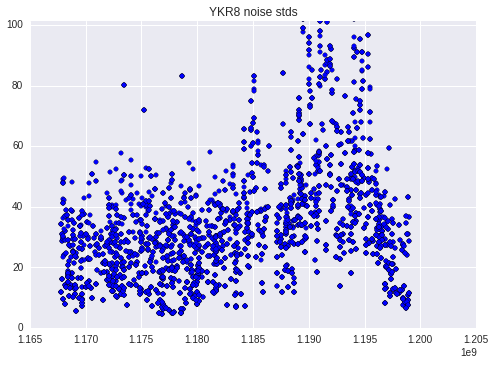

In [9]:
sites="ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
for site in sites:
    sta = Sigvisa().get_default_sta(site)
    try:
        plot_levels(sta, runid=25)
    except Exception as e:
        print "exception at %s: %s" % (site, e)

It definitely looks like there are two scales of signal, trading off in contiguous periods of varying length. Argh this is annoying. 

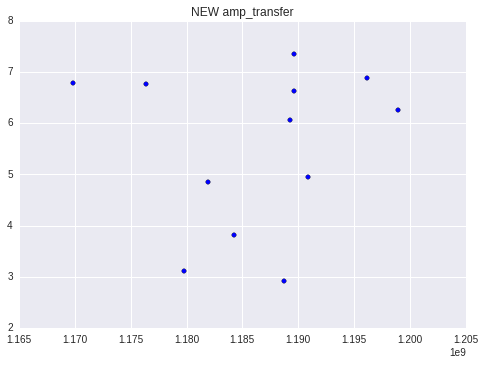

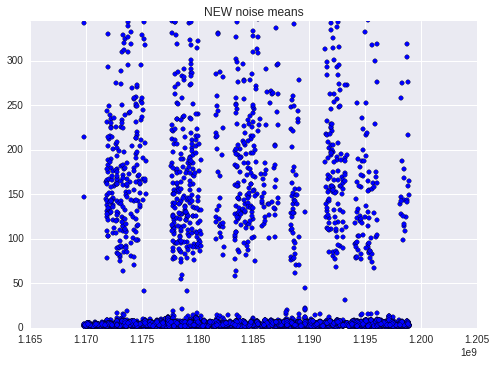

In [9]:
runid=24
r, r2 = plot_levels("NEW", runid=runid)

(0, 366.2238154500003)

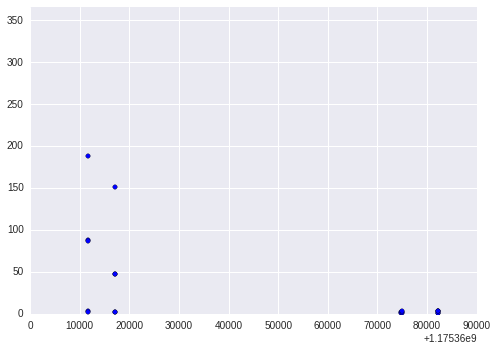

In [66]:
plt.scatter(r2[:, 0], r2[:, 1])
plt.xlim([1175360000, 1175450000])
plt.ylim([0, np.percentile(r2[:, 1], 99)])

In [4]:
from sigvisa.signals.io import fetch_waveform

In [5]:
#w = fetch_waveform(station="NEW", chan="BHZ", stime=1174800000, etime=1175200000) #small
#w2 = fetch_waveform(station="NEW", chan="BHZ", stime=1194622932, etime=1194623376) # large
#w3 = fetch_waveform(station="NEW", chan="BHZ", stime=1190000000, etime=1190100000) # small
#w3 = fetch_waveform(station="NEW", chan="BHZ", stime=1192000000, etime=1192100000) # large?

w3 = fetch_waveform(station="NEW", chan="BHZ", stime=1191422000, etime=1191423000)

print w3["stime"], w3["etime"]

[('BHZ', 1191196800.0, 1191422872.5, 40.0, 9042901L, 'NEW/sac2007001-2008091', '2007.274.00.00.00.0000.US.NEW..BHZ.M.SAC'), ('BHZ', 1191332381.525001, 1191422567.500001, 40.0, 3607440L, 'NEW/sac2007001-2008091', '2007.275.13.39.41.5250.US.NEW.HR.BHZ.M.SAC'), ('BHZ', 1191422652.45, 1193410830.775, 40.0, 79527134L, 'NEW/sac2007001-2008091', '2007.276.14.44.12.4500.US.NEW.HR.BHZ.M.SAC'), ('BHZ', 1191422883.525, 1192665385.0, 40.0, 49700060L, 'NEW/sac2007001-2008091', '2007.276.14.48.03.5250.US.NEW..BHZ.M.SAC')]
1191421980 1191423020.0


(-1500, 1500)

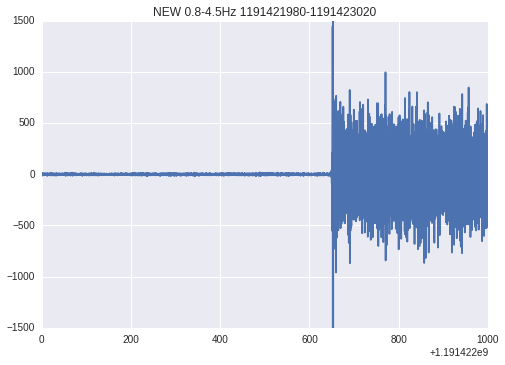

In [142]:
wf = w3.filter("freq_0.8_4.5")
t = np.linspace(w3["stime"], w3["etime"], len(w3.data))
plt.plot(t, wf.data)
plt.title("NEW 0.8-4.5Hz %.0f-%.0f" % (w3["stime"], w3["etime"]))
plt.ylim([-1500, 1500])

In [10]:
s = Sigvisa()
sql = "select chan, stime, etime, hz, npts, subdir, fname from llnl_wfdisc where sta = '%s' and chan='BHZ' and stime < %f and etime > %f and hz > 9.0 " % (
    "NEW", 1191423000, 1191422000)

waveforms = s.sql(sql)
print waveforms



(('BHZ', 1191196800.0, 1191422872.5, 40.0, 9042901L, 'NEW/sac2007001-2008091', '2007.274.00.00.00.0000.US.NEW..BHZ.M.SAC'), ('BHZ', 1191422652.45, 1193410830.775, 40.0, 79527134L, 'NEW/sac2007001-2008091', '2007.276.14.44.12.4500.US.NEW.HR.BHZ.M.SAC'), ('BHZ', 1191422883.525, 1192665385.0, 40.0, 49700060L, 'NEW/sac2007001-2008091', '2007.276.14.48.03.5250.US.NEW..BHZ.M.SAC'), ('BHZ', 1191332381.525001, 1191422567.500001, 40.0, 3607440L, 'NEW/sac2007001-2008091', '2007.275.13.39.41.5250.US.NEW.HR.BHZ.M.SAC'))


6.29145e+08
3.35544e+10
6.29145e+08
3.35544e+10


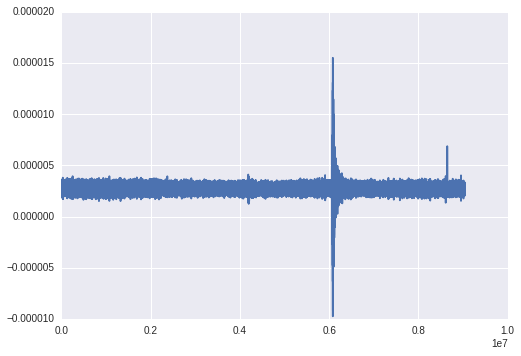

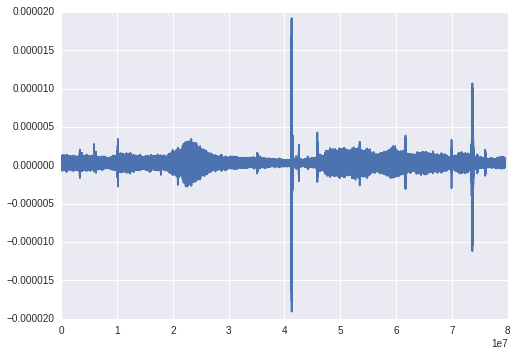

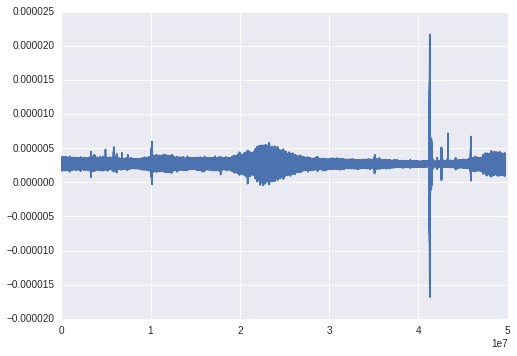

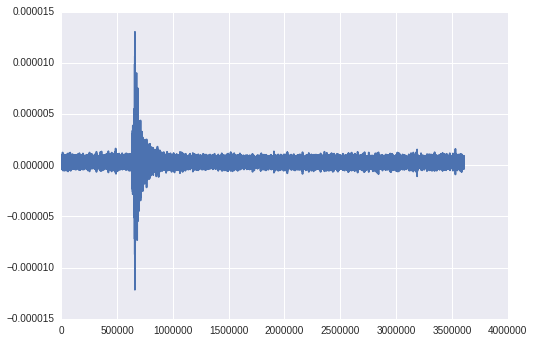

In [21]:
import obspy
import os
base_dir = os.path.join("/media/usb0/ctbt/llnl_data/")
for (chan, wave_stime, wave_etime, wave_hz, wave_npts, subdir, fname) in waveforms:
    fullpath = os.path.join(base_dir, subdir, fname)

    st = obspy.read(fullpath)
    print st[0].stats["calib"]
    plt.figure()
    plt.plot(st[0].data / st[0].stats["calib"])

In [18]:
print st[0].stats

         network: US
         station: NEW
        location: 
         channel: BHZ
       starttime: 2007-10-01T00:00:00.000000Z
         endtime: 2007-10-03T14:47:52.500000Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 9042901
           calib: 6.29145e+08
         _format: SAC
             sac: AttribDict({u'dist': -12345.0, u'isynth': -12345, u'depmin': -12345.0, u'iftype': 1, u'kuser0': u'-12345  ', u'kuser1': u'-12345  ', u'kuser2': u'-12345  ', u'gcarc': -12345.0, u'iinst': -12345, u'ymaximum': -12345.0, u'kevnm': u'-12345          ', u'iqual': -12345, u'unused13': 0, u'cmpinc': 0.0, u'imagsrc': -12345, u'norid': 0, u'unused11': -12345.0, u'unused10': -12345.0, u'lpspol': 0, u'unused12': -12345.0, u'leven': 1, u't8': -12345.0, u't9': -12345.0, u't6': -12345.0, u't7': -12345.0, u't4': -12345.0, u't5': -12345.0, u't2': -12345.0, u't3': -12345.0, u't0': -12345.0, u't1': -12345.0, u'istreg': -12345, u'baz': -12345.0, u'yminimum': -12345.0, u'evla': -12345.0, u'xm

In [9]:
import obspy
s = Sigvisa()
cursor = s.dbconn.cursor()
r = s.sql("select id, subdir, fname from llnl_wfdisc")
n = len(r)
base_dir = os.path.join("/media/usb0/ctbt/llnl_data/")
for i, (wid, subdir, fname) in enumerate(r):
    fullpath = os.path.join(base_dir, subdir, fname)
    st = obspy.read(fullpath, headonly=True)
    calib = st[0].stats["calib"]    
    cursor.execute("update llnl_wfdisc set calib=%f where id=%d" % (calib, wid))
    if i % 1000 == 0:
        print "%d/%d: " % (i, n), fname, calib
cursor.close()
s.dbconn.commit()

0/149100:  2008.091.11.58.38.0550.II.PFO.00.ENZ.M.SAC 550425.0
1000/149100:  2007.147.02.51.42.9949.II.PFO.00.LHE.M.SAC 1.2955e+10
2000/149100:  2007.260.15.25.20.0000.IM.NV01..SHZ.M.SAC 9.22659e+09
3000/149100:  2007.345.14.20.30.0000.IM.NV31..BHZ.M.SAC 1.57286e+10
4000/149100:  2007.253.16.18.20.0000.IM.NV31..BHE.M.SAC 1.57286e+10
5000/149100:  2007.340.07.33.50.0000.IM.NV31..BHE.M.SAC 1.57286e+10
6000/149100:  2007.155.13.45.40.0000.IM.NV31..BHE.M.SAC 1.57286e+10
7000/149100:  2007.039.17.41.34.0000.IM.NV31..BHN.M.SAC 1.57286e+10
8000/149100:  2007.012.02.25.24.0000.IM.NV31..BHN.M.SAC 1.57286e+10
9000/149100:  2007.007.17.06.28.0000.IM.NV31..BHZ.M.SAC 1.57286e+10
10000/149100:  2007.156.04.43.00.0000.IM.NV01..SHZ.M.SAC 9.22659e+09
11000/149100:  2007.101.10.09.20.0000.IM.NV01..SHZ.M.SAC 9.22659e+09
12000/149100:  2007.101.10.37.18.0000.IM.NV31..BHZ.M.SAC 1.57286e+10
13000/149100:  2007.076.21.50.10.0000.IM.NV31..BHZ.M.SAC 1.57286e+10
14000/149100:  2007.100.22.00.45.0000.IM.NV01..SH

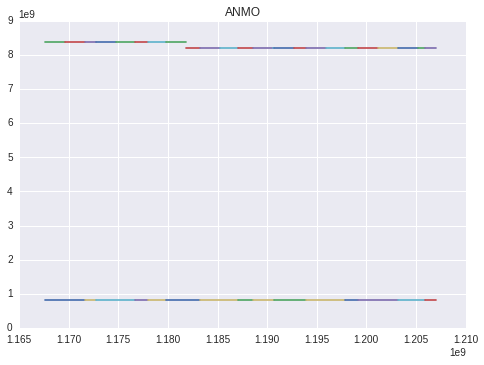

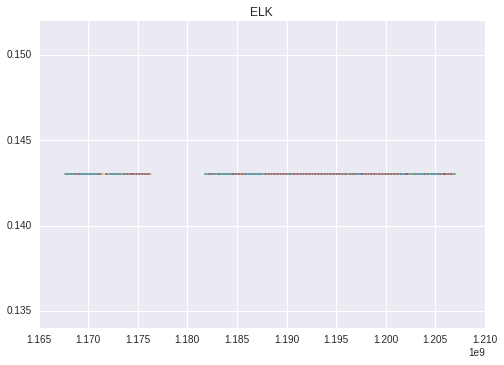

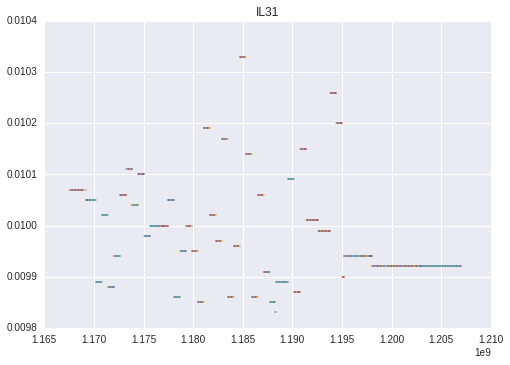

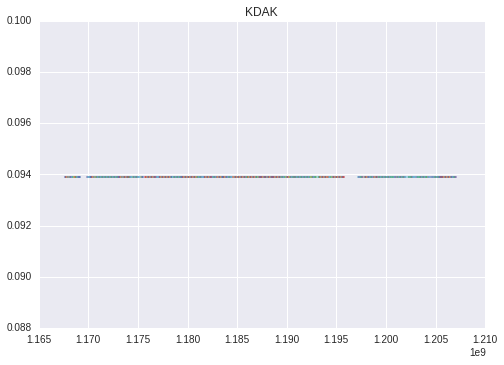

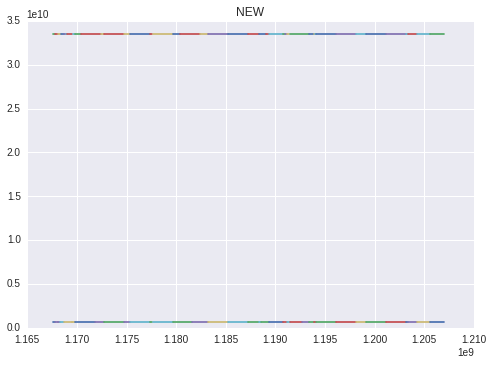

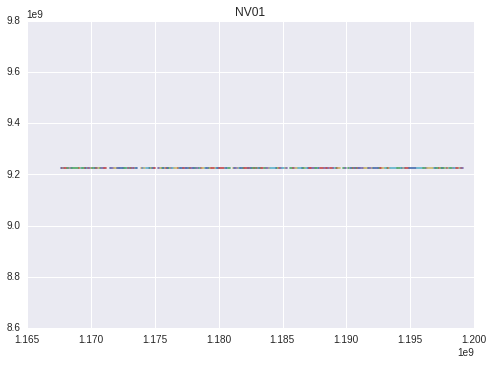

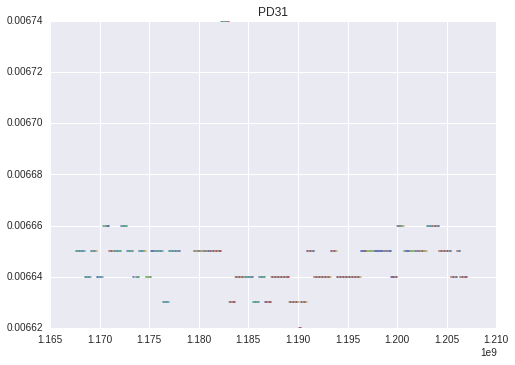

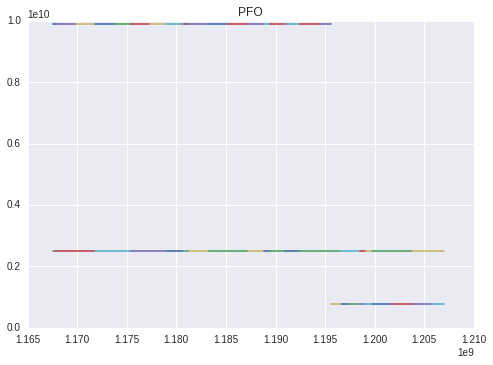

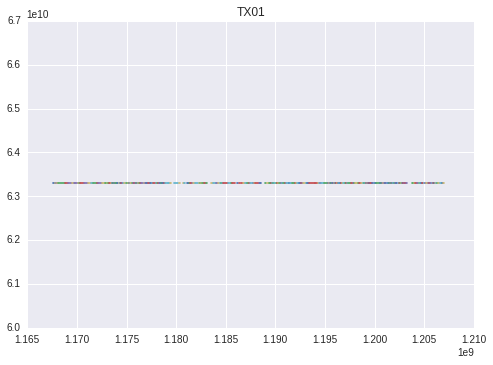

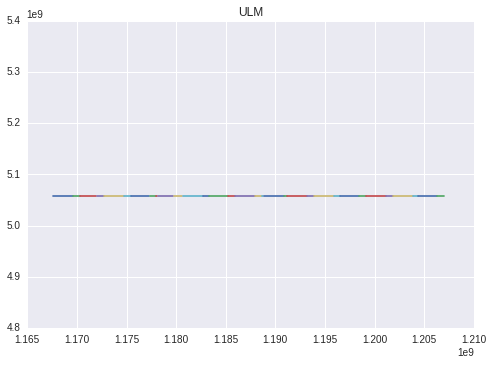

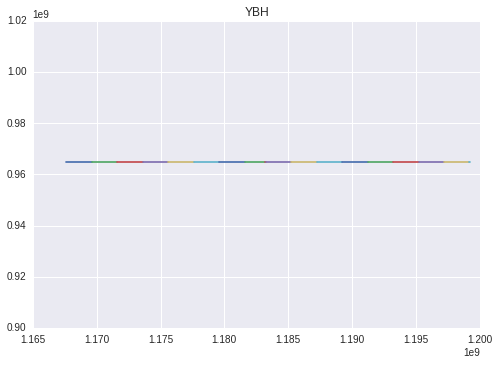

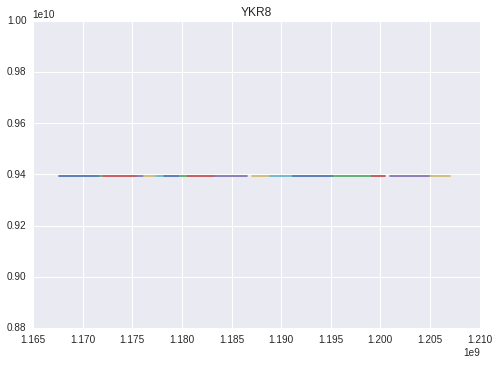

In [28]:
sites="ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
for site in sites:
    sta = Sigvisa().get_default_sta(site)

    plt.figure()
    r = s.sql("select stime, etime, calib, fname from llnl_wfdisc where sta='%s' and (chan='BHZ' or chan='SHZ') order by stime" % sta)
    for (stime, etime, calib, fname) in r:
        plt.plot((stime, etime), (calib, calib))
    plt.title(sta)
